<a href="https://colab.research.google.com/github/davidisinta/deep_learning/blob/main/pset2_complete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

David Nyakawa

In [ ]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

Mounted at /content/gdrive


In [ ]:
#hide
from fastbook import *
from fastai.vision.widgets import *

Mounts google drive to the notebook:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Display the different types of bears as folders in google drive:


In [ ]:
!ls /content/drive/MyDrive/bears



black  grizzly	teddy


Display an image from the bears folder to verify connection:

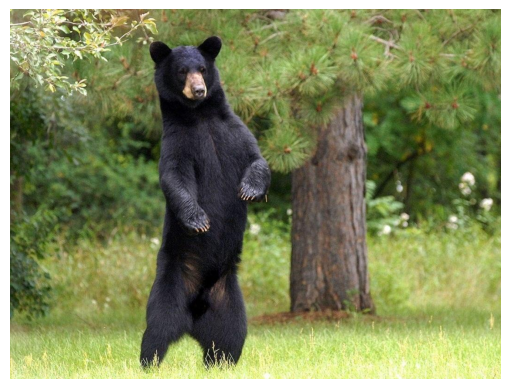

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# Load the image
img_path = '/content/drive/MyDrive/bears/black/0ccf58bd-d282-424f-ae6e-5b051e61083c.jpg'
img = Image.open(img_path)

# Display the image
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()

Set the path to bears folder as path to data:

In [ ]:
bear_types = 'grizzly','black','teddy'
path = Path('/content/drive/MyDrive/bears/')

Display the image files in the folder to confirm expected behaviour:

In [ ]:
fns = get_image_files("/content/drive/MyDrive/bears/")
fns

(#396) [Path('/content/drive/MyDrive/bears/grizzly/85460157-c6ca-41d7-8bd6-136973e1c078.jpg'),Path('/content/drive/MyDrive/bears/grizzly/9c6c100d-47fc-4a86-a81b-4f2679594815.jpg'),Path('/content/drive/MyDrive/bears/grizzly/b7a17594-d655-4901-b543-1d6e669a90f3.jpg'),Path('/content/drive/MyDrive/bears/grizzly/1a58a1d8-9d61-4614-95cf-f78f27b5b9ef.jpg'),Path('/content/drive/MyDrive/bears/grizzly/e75698ee-c193-491e-9371-6f3038e29d45.jpg'),Path('/content/drive/MyDrive/bears/grizzly/8e711118-2260-4b06-9965-46a913336b99.jpg'),Path('/content/drive/MyDrive/bears/grizzly/e996e14a-1864-4c52-8369-653ea97dec87.jpg'),Path('/content/drive/MyDrive/bears/grizzly/4edbdc55-2dce-47f2-92d9-482acd86f8a4.jpg'),Path('/content/drive/MyDrive/bears/grizzly/3fc5db69-8fc5-49f1-be9e-c94f45e9d5ec.jpg'),Path('/content/drive/MyDrive/bears/grizzly/f6303e16-13d2-4144-b31d-eaffed14323f.jpg')...]

Verify that none of the files in the folder is corrupt:

In [ ]:
failed = verify_images(fns)
failed

(#0) []

Delete any corrupt image files:

In [ ]:
failed.map(Path.unlink);

Create a data loader for the bears:

In [ ]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

Create data loader objects from the files in the specified path:


In [ ]:
dls = bears.dataloaders(path)

Display a few Data loaders to confirm correct serialization of data:

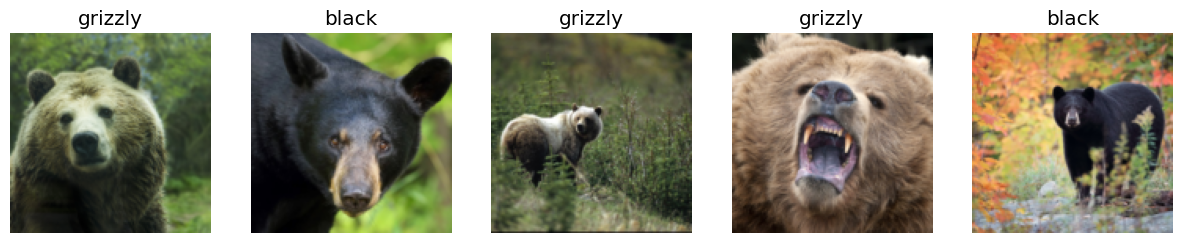

In [ ]:
dls.valid.show_batch(max_n=5, nrows=1)

Data Augmentation

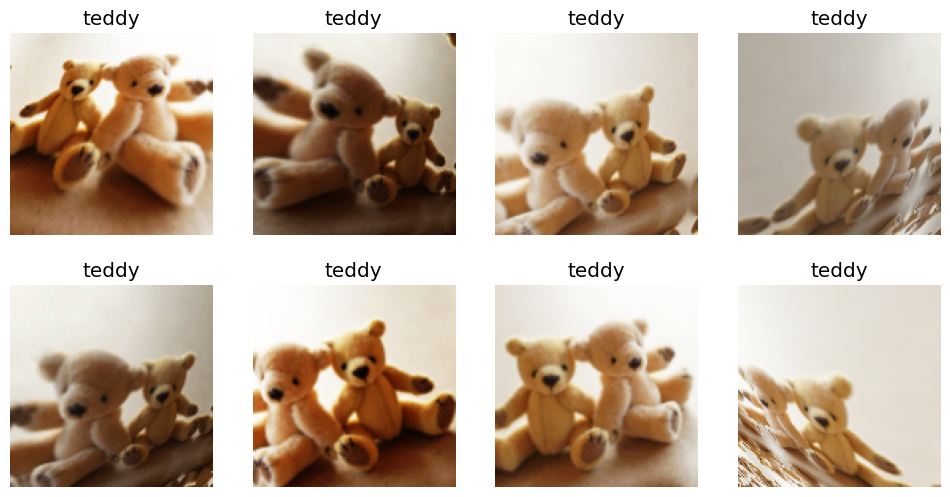

In [ ]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

Model training:

In [ ]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

In [ ]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 64.1MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.701089,0.142566,0.037975,01:37


epoch,train_loss,valid_loss,error_rate,time
0,0.262986,0.058491,0.012658,01:59
1,0.218501,0.017060,0.000000,02:00
2,0.163237,0.008825,0.000000,01:57
3,0.137554,0.007477,0.000000,02:02


Analyze model mistakes:

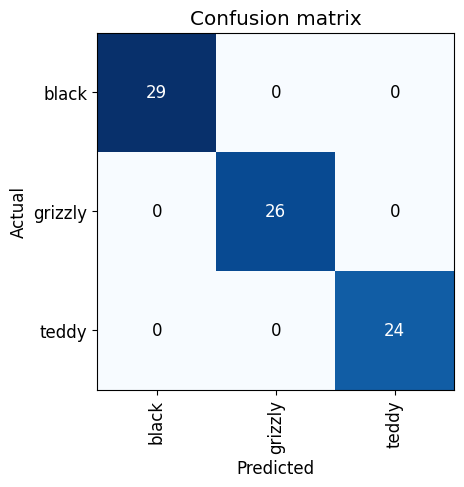

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

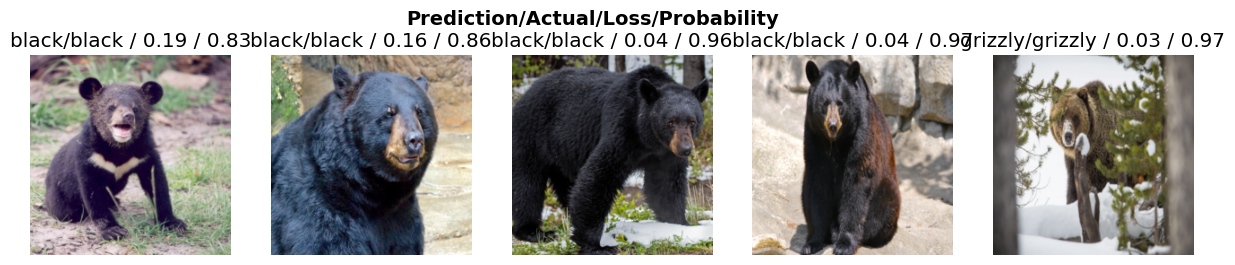

In [ ]:
interp.plot_top_losses(5, nrows=1)

Turning model into an application

In [ ]:
learn.export()

In [ ]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [ ]:
learn_inf = load_learner(path/'export.pkl')

The predict model is what would be integrated into a fullstack app as an API endpoint for example.

In [ ]:
learn_inf.predict('/content/drive/MyDrive/bears/black/0ccf58bd-d282-424f-ae6e-5b051e61083c.jpg')

('black', tensor(0), tensor([1.0000e+00, 3.2734e-07, 8.3476e-07]))

In [ ]:
learn_inf.dls.vocab

['black', 'grizzly', 'teddy']

Creating an interactive window:


In [ ]:
btn_upload = SimpleNamespace(data = ['/content/drive/MyDrive/bears/black/0ccf58bd-d282-424f-ae6e-5b051e61083c.jpg'])

In [ ]:
img = PILImage.create(btn_upload.data[-1])

In [ ]:
#hide_output
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

Get the models prediction

In [ ]:
pred,pred_idx,probs = learn_inf.predict(img)

In [ ]:
#hide_output
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: black; Probability: 1.0000')

Interactive button for classification:

In [ ]:
#hide_output
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

button event handler:

In [ ]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [ ]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [ ]:
#hide_output
VBox([widgets.Label('Select your bear!'),
      btn_upload, btn_run, out_pl, lbl_pred])

Deploy app:

In [ ]:
!pip install voila
!jupyter serverextension enable --sys-prefix voila

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.1/106.1 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.3/157.3 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 3.9 MB/s eta 0:00:00
  Attempting uninstall: jupyter-client
    Found existing installation: jupyter-client 6.1.12
    Uninstalling jupyter-client-6.1.12:
      Successfully uninstalled jupyter-client-6.1.12
  Attempting uninstall: jupyter-server
    Found existing installation: jupyter-server 1.24.0
    Uninstalling jupyter-server-1.24.0:
      Successfully uninstalled jupyter-server-1.24.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following

In [53]:
!ls


drive  export.pkl  gdrive  sample_data


In [50]:
!cd /content/drive

In [51]:
!ls

drive  export.pkl  gdrive  sample_data
